<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Строится модель для такого предсказания.



## Подготовка

Загрузим требуемые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor

Загрузим данные и выведем на экран общую иформацию и первых 5 строк датафрейма.

In [ ]:
# переведем столбец с датой в индексы
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу.

In [ ]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Проведем анализ данных. Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

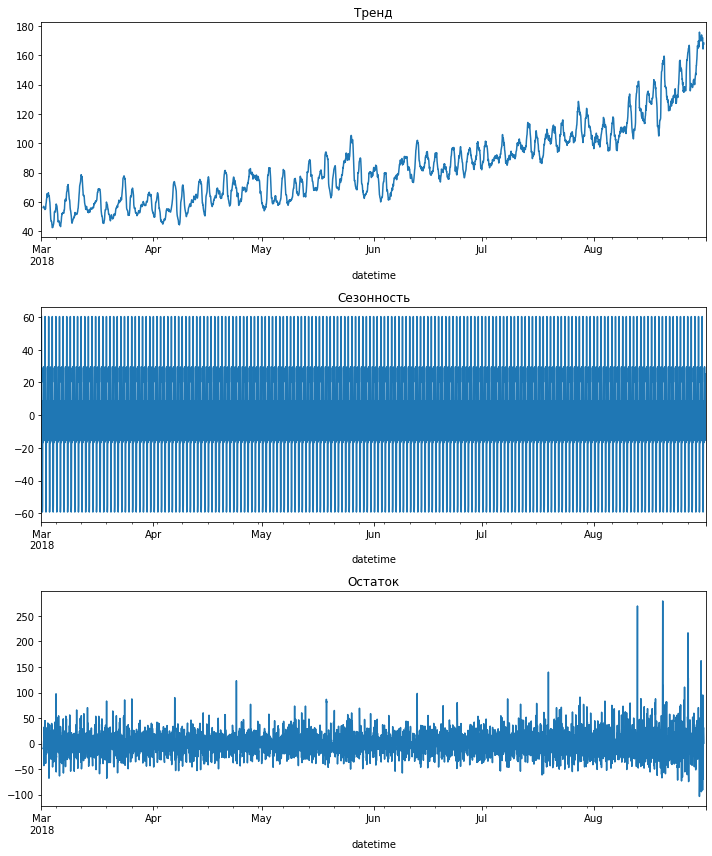

In [ ]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

На графике для всего датафрейма видно, что наблюдается восходящий тренд с течением времени. Заметно так же постепенное увеличение шума в данных.

Сделаем разложение временного ряда для промежутков в месяц и неделю.

In [ ]:
df_month = df['2018-08-1':'2018-08-31']

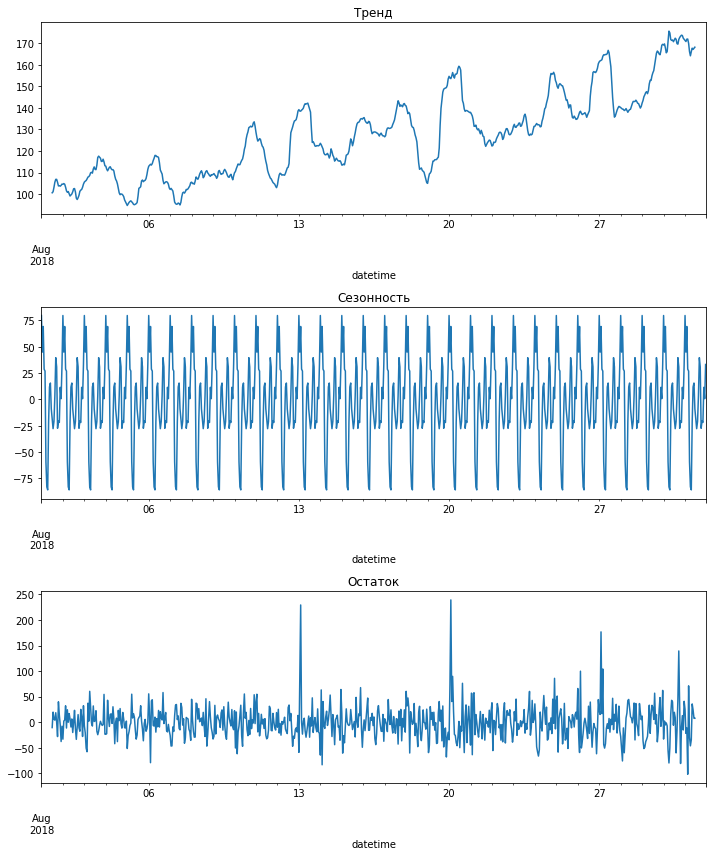

In [ ]:
decomposed = seasonal_decompose(df_month)

plt.figure(figsize=(10, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

На периоде в месяц явно видно увеличение количества заказов по субботам и понедельникам, наш ряд явно имеет зависимость от дня недели.

In [ ]:
df_week = df['2018-08-20':'2018-08-26']

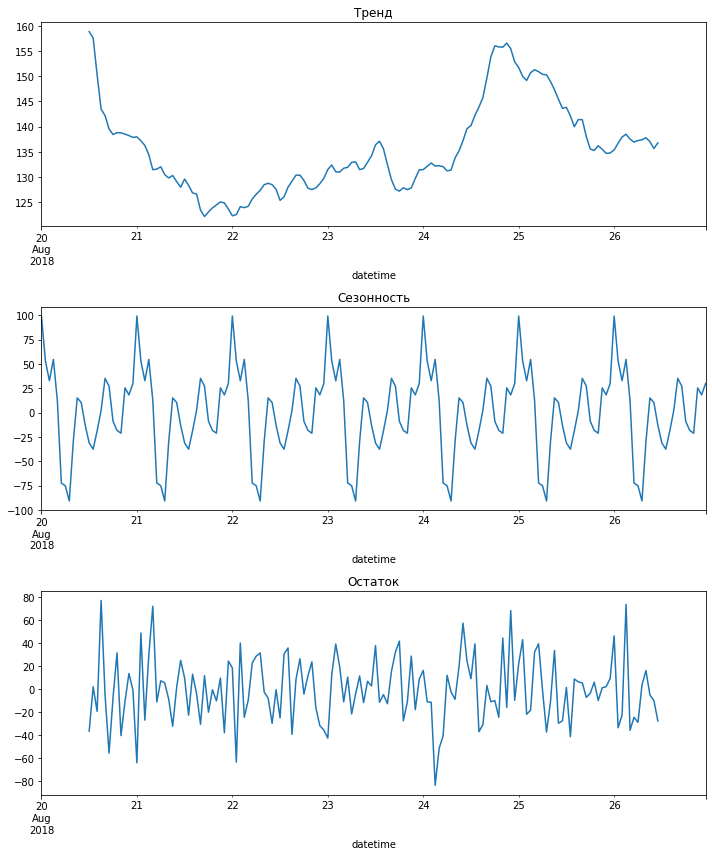

In [ ]:
decomposed = seasonal_decompose(df_week)

plt.figure(figsize=(10, 12))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())# < напишите код здесь >
plt.title('Остаток')
plt.tight_layout()

На недельном графике видно сезонность в течении суток, кол-во заказов меняется в зависимости от времени.

**Вывод**

С течением времени общее количество заказов увеличивается, так же постепенно увеличивается количество шума в данных.

Заметно увеличение количества заказов по субботам и понедельникам, имеется зависимость от дня недели.

Данные имеют выраженную сезонность в течении суток, кол-во заказов меняется в зависимости от часа.

Подготовим наши данные для обучения моделей.

Создадим новые признаки для датафрейма:

- в качестве календарных используем месяц, день и день недели
- отстающие значения
- скользящее среднее

In [ ]:
# Создадим функцию которая на вхо принимает датафрейм,
# размер отставания для отстающих значений и размер окна для скользящего среднего
# а возвращает датафрейм с новыми признаками

def make_features(df, max_lag, rolling_mean_size):
    #df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Применим функцию к нашим данным. Для скользящего среднего используем размер окна 24, по количеству часов в сутках, для отстающих значений используем размер отставания в 168 часов(кол-во часов в неделе), так как явно выявили зависимость количества заказов от дня недели.

In [ ]:
make_features(df, 168, 24)
df.head()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовые выборки.

In [ ]:
# используем параметр shuffle=False, чтобы в тест попали только самые поздние по времени данные
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Проверим корректность разделения данных

In [ ]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Временные интервалы не пересекаются, тестовые данные идут после обучающих. Датасет разделен правильно

Удалим из обучающей выборки строки с пропусками, выведем размеры выборок на экран

In [ ]:
train = train.dropna()

In [ ]:
train.shape

(3806, 172)

In [ ]:
test.shape

(442, 172)

Выделим целевой признак ипризаки для каждой выборки.

In [ ]:
target_train = train['num_orders']
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)
features_train = train.drop('num_orders', axis=1)

## Обучение

Обучим модели LinearRegression, RandomForestRegressor, CatBoostRegressor подберем гиперпараметры и проверим кросс-валидацией.

Для оценки качества прогнозов используем метрику RMSE - она представляет собой стандартное отклонение выборки различий между предсказанными и наблюдаемыми значениями и хорошо подходит для оценки точности прогноза

Для кросс-валидации используем метод TimeSeriesSplit() для разделения обучающей выборки на части

In [ ]:
time_split= TimeSeriesSplit(n_splits=3)

Обучим модель Линейной регрессии, проверим качество метрикой RMSE на валидации

In [ ]:
%%time

model_linear =LinearRegression()

scores = cross_val_score(model_linear, features_train, target_train,scoring = 'neg_root_mean_squared_error',  cv=time_split)
final_score = pd.Series(scores).mean()
final_score

CPU times: user 813 ms, sys: 957 ms, total: 1.77 s
Wall time: 2.07 s


-23.055599746367466

Обучим модель Случайного леса и подберем для нее гиперпараметры.

In [ ]:
%%time

model_random = RandomForestRegressor()
parametrs = { 'n_estimators': range (50, 100, 10),
              'max_depth': range (1,13, 2),
              'random_state':[12345]}

grid = GridSearchCV(model_random, parametrs, cv= time_split,scoring='neg_root_mean_squared_error')
model_grid_random = grid.fit(features_train, target_train)

print('Параметры лучшей модели:', model_grid_random.best_params_)
print('RMSE:', model_grid_random.best_score_)

Параметры лучшей модели: {'max_depth': 11, 'n_estimators': 90, 'random_state': 12345}
RMSE: -23.653089428293626
CPU times: user 7min 29s, sys: 491 ms, total: 7min 30s
Wall time: 7min 31s


Обучим модель CatBoost оценим качество и найдем лучшие гиперпараметры

In [ ]:
%%time

model_catboost = CatBoostRegressor()
parametrs = { 'iterations': range (50, 100, 10),
              'depth': range (1,13, 2),
              'random_state':[12345]}

grid = GridSearchCV(model_catboost, parametrs, cv=time_split,scoring='neg_root_mean_squared_error')
model_grid_cat = grid.fit(features_train, target_train, verbose = False)

print('Параметры лучшей модели:', model_grid_cat.best_params_)
print('RMSE:', model_grid_cat.best_score_)

Параметры лучшей модели: {'depth': 3, 'iterations': 90, 'random_state': 12345}
RMSE: -23.835267814416937
CPU times: user 13min 54s, sys: 4.01 s, total: 13min 58s
Wall time: 15min 13s


Лучший результат на кросс-валидации показала модель CatBoost, результат модели LinearRegression тоже соответствует задаче, а скорость ее обучения выше чем у CatBoost.

Проверим обе модели на тестовой выборке.

## Тестирование

Проверим модель линейной регрессии на тестовых данных.

In [ ]:
model_linear.fit(features_train, target_train)

predict_test = model_linear.predict(features_test)

mean_squared_error(target_test, predict_test, squared=False)

34.72805588778468

RMSE на тестовых данных составил 34.72, что ниже требуемых 48.

Проверим модель CatBoost на тестовых данных.

In [ ]:
predict_test = model_grid_cat.best_estimator_.predict(features_test)

mean_squared_error(target_test, predict_test, squared=False)

40.897943532545895

RMSE на тестовых данных составил 40.89, что ниже требуемых 48.

Модель линейной регрессии показала лучший результат на тестовой выборке.

Проверим модель на адекватность, сравним результат с константной моделью.

In [ ]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

mean_squared_error(target_test, pred_previous, squared=False)

58.856486242815066

Метрика RMSE у лучшей модели меньше чем у константной, наша модель адекватна.

## Общий вывод

С течением времени общее количество заказов увеличивается, так же постепенно увеличивается количество шума в данных.

Заметно увеличение количества заказов по субботам и понедельникам, имеется зависимость от дня недели.

Данные имеют выраженную сезонность в течении суток, кол-во заказов меняется в зависимости от часа.

Обучили три модели: LinearRegression, RandomForestRegressor, CatBoostRegressor

Лучшее качество показала модель LinearRegression, на тестовых данных метрика RMSE составила 34.72 и не превышает требуемых 48.

Модель прошла проверку на адекватность.
